In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import xgboost as xgb
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import variation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, pacf
import nolds
from torch.utils.data import DataLoader, TensorDataset
from pyentrp import entropy as ent
from scipy.stats import variation
from scipy import fft
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
df = pd.read_csv('/kaggle/input/traffic/traffic.csv')

In [5]:
df

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


In [6]:
df = df.groupby('DateTime').sum()

df.index = pd.to_datetime(df.index)
cutoff_date = '2017-01-01 00:00:00'
cutoff_date = pd.to_datetime(cutoff_date)

df = df[df.index > cutoff_date]

# Получаем данные
data = df['Vehicles'].dropna().values
dates = df.index.dropna()  
len(data)


4343

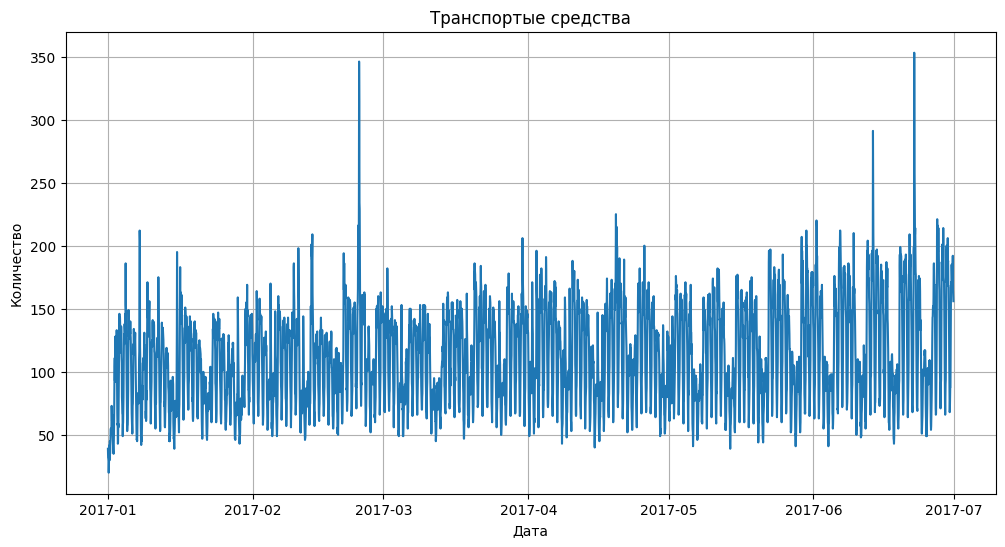

In [ ]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(dates, data)
plt.title('Транспортые средства')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.grid(True)
plt.show()


In [8]:
print(f"Среднее значение: {np.mean(data)}")
print(f"Медиана: {np.median(data)}")
print(f"Стандартное отклонение: {np.std(data)}")
print(f"Первый квартиль (Q1): {np.percentile(data, 25)}")
print(f"Третий квартиль (Q3): {np.percentile(data, 75)}")
print(f"Межквартильный размах (IQR): {np.percentile(data, 75) - np.percentile(data, 25)}")

Среднее значение: 111.10568731291734
Медиана: 106.0
Стандартное отклонение: 39.26832099463669
Первый квартиль (Q1): 79.0
Третий квартиль (Q3): 141.0
Межквартильный размах (IQR): 62.0


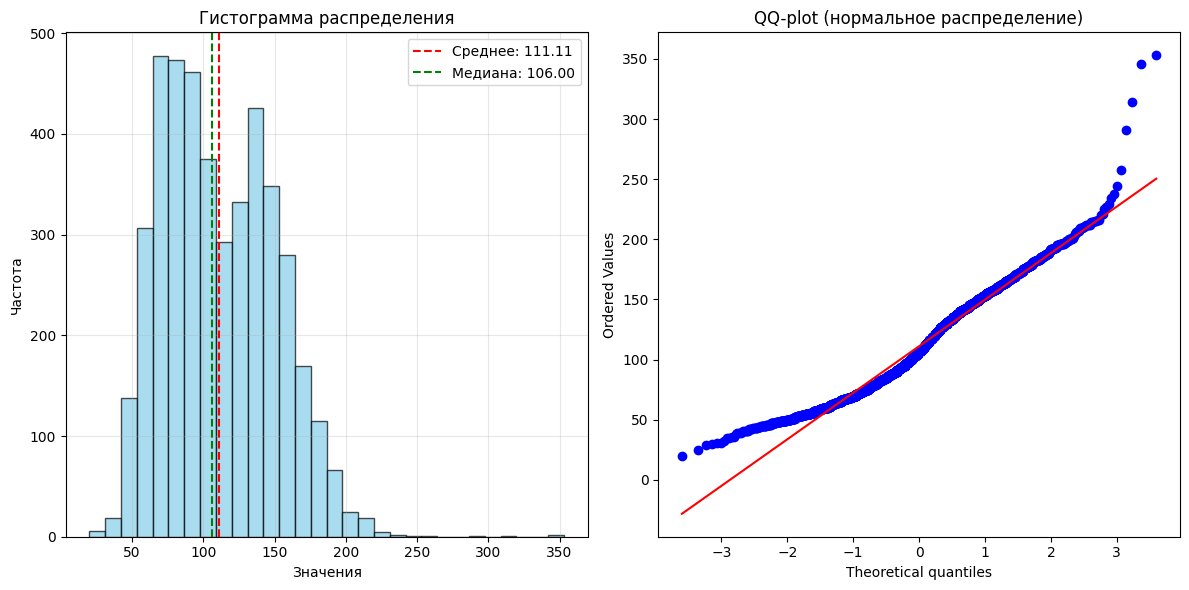

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(data), color='red', linestyle='--', label=f'Среднее: {np.mean(data):.2f}')
plt.axvline(np.median(data), color='green', linestyle='--', label=f'Медиана: {np.median(data):.2f}')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Гистограмма распределения')
plt.legend()
plt.grid(alpha=0.3)
    
# QQ-plot для проверки нормальности распределения
plt.subplot(1, 2, 2)
stats.probplot(data, dist="norm", plot=plt)
plt.title('QQ-plot (нормальное распределение)')
    
plt.tight_layout()
plt.show()

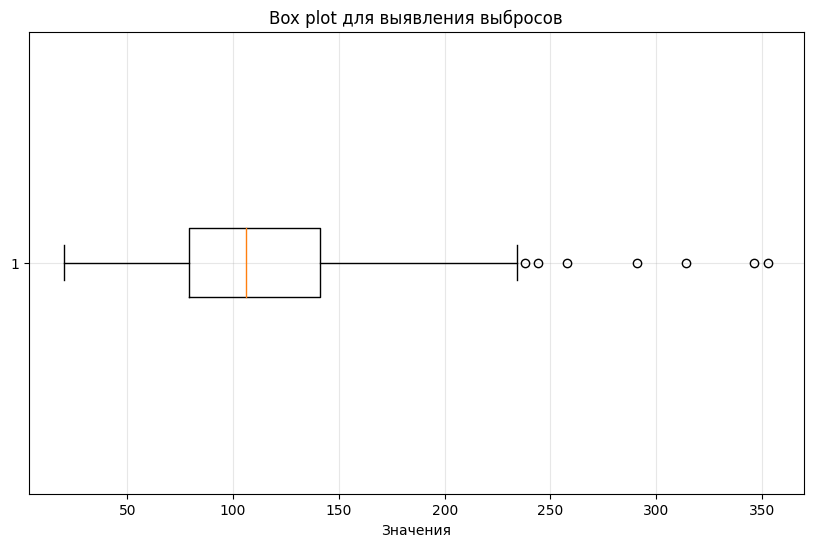

In [10]:
plt.figure(figsize=(10, 6))
plt.boxplot(data, vert=False)
plt.title('Box plot для выявления выбросов')
plt.xlabel('Значения')
plt.grid(alpha=0.3)
plt.show()

In [11]:
z_scores = np.abs(stats.zscore(data))
outliers = data[z_scores > 3]
print(f"Количество выбросов: {len(outliers)}")
print(f"Процент выбросов: {len(outliers)/len(data)*100:.2f}%")
    
if len(outliers) > 0:
    print("Выбросы:")
    for i, outlier in enumerate(outliers):
        print(f"  Выброс {i+1}: {outlier:.4f} (z-score: {z_scores[data == outlier][0]:.2f})")

Количество выбросов: 9
Процент выбросов: 0.21%
Выбросы:
  Выброс 1: 238.0000 (z-score: 3.23)
  Выброс 2: 346.0000 (z-score: 5.98)
  Выброс 3: 314.0000 (z-score: 5.17)
  Выброс 4: 234.0000 (z-score: 3.13)
  Выброс 5: 229.0000 (z-score: 3.00)
  Выброс 6: 291.0000 (z-score: 4.58)
  Выброс 7: 244.0000 (z-score: 3.38)
  Выброс 8: 353.0000 (z-score: 6.16)
  Выброс 9: 258.0000 (z-score: 3.74)


In [12]:
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = data[(data < lower_bound) | (data > upper_bound)]

print(f"Количество выбросов (IQR метод): {len(outliers_iqr)}")
for i, outlier in enumerate(outliers_iqr):
        print(f"Выброс {i+1}: {outlier:.4f} ")
        

Количество выбросов (IQR метод): 7
Выброс 1: 238.0000 
Выброс 2: 346.0000 
Выброс 3: 314.0000 
Выброс 4: 291.0000 
Выброс 5: 244.0000 
Выброс 6: 353.0000 
Выброс 7: 258.0000 


In [13]:
ts = pd.Series(data, index=dates)

In [14]:
result_mul = seasonal_decompose(ts, model='multiplicative', period=168)

<Figure size 1500x1200 with 0 Axes>

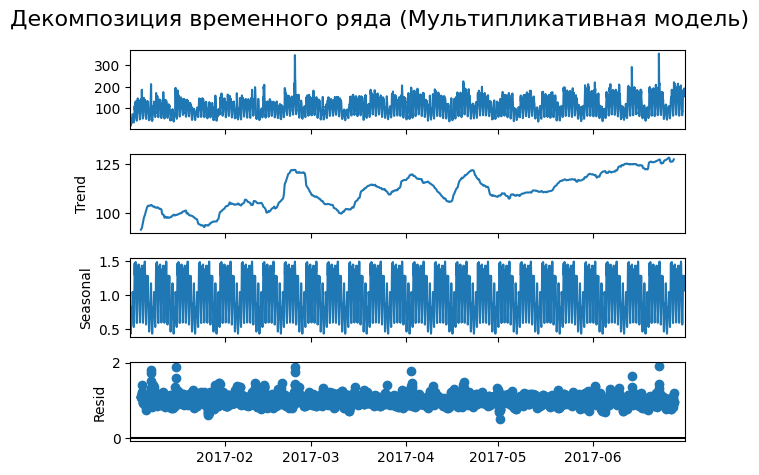

In [15]:
plt.figure(figsize=(15, 12))
result_mul.plot()
plt.suptitle('Декомпозиция временного ряда (Мультипликативная модель)', fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

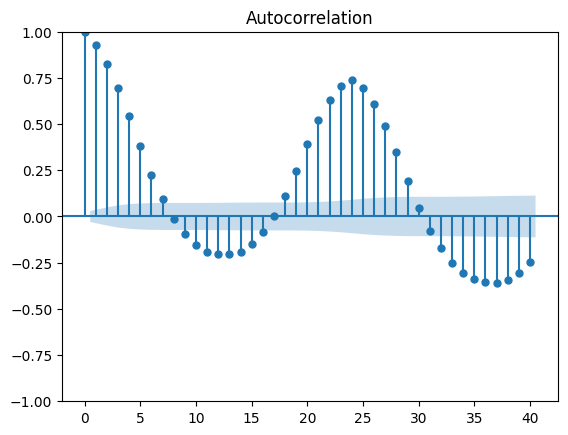

In [16]:
plt.figure(figsize=(10, 6))
plot_acf(ts, lags=40, alpha=0.05)
plt.show()

<Figure size 1000x600 with 0 Axes>

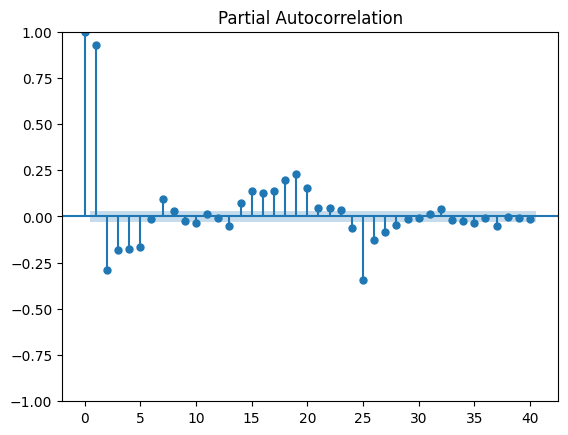

In [17]:
plt.figure(figsize=(10, 6))
plot_pacf(ts, lags=40, alpha=0.05, method='ywm')
plt.show()



In [18]:
result = adfuller(ts)
    
# Извлекаем результаты
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]
    
# Выводим результаты
print(f'ADF статистика: {adf_statistic}')
print(f'p-value: {p_value}')
print('\nКритические значения:')
for key, value in critical_values.items():
    print(f'   {key}: {value:.4f}')

ADF статистика: -8.498986871187505
p-value: 1.25319517220543e-13

Критические значения:
   1%: -3.4319
   5%: -2.8622
   10%: -2.5671


In [19]:
dates

DatetimeIndex(['2017-01-01 01:00:00', '2017-01-01 02:00:00',
               '2017-01-01 03:00:00', '2017-01-01 04:00:00',
               '2017-01-01 05:00:00', '2017-01-01 06:00:00',
               '2017-01-01 07:00:00', '2017-01-01 08:00:00',
               '2017-01-01 09:00:00', '2017-01-01 10:00:00',
               ...
               '2017-06-30 14:00:00', '2017-06-30 15:00:00',
               '2017-06-30 16:00:00', '2017-06-30 17:00:00',
               '2017-06-30 18:00:00', '2017-06-30 19:00:00',
               '2017-06-30 20:00:00', '2017-06-30 21:00:00',
               '2017-06-30 22:00:00', '2017-06-30 23:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=4343, freq=None)

In [20]:
def create_features(prices, dates):
    prices_series = pd.Series(prices, index=dates)
    
    features = pd.DataFrame(index=dates)

    # Лаговые переменные и доходности
    for lag in range(1, 7):
        features[f'lag_{lag}'] = prices_series.shift(lag)
        features[f'lag24_{lag}'] = prices_series.shift(lag*24)
        features[f'returns_{lag}'] = prices_series.pct_change(lag)
        features[f'log_{lag}'] = np.log(prices_series.shift(lag))
        features[f'diff_{lag}'] = prices_series - prices_series.shift(lag)

    # Скользящие средние и волатильность (стандартное отклонение)
    for window in [3, 5, 7, 14, 21, 30]:
        features[f'ma_{window}'] = prices_series.rolling(window).mean()
        features[f'std_{window}'] = prices_series.rolling(window).std()  
        features[f'median_{window}'] = prices_series.rolling(window).median()  
        features[f'min_{window}'] = prices_series.rolling(window).min()  
        features[f'max_{window}'] = prices_series.rolling(window).max()  
        features[f'range_{window}'] = prices_series.rolling(window).max()-prices_series.rolling(window).min()
        features[f'var_{window}'] = prices_series.rolling(window).var()  

    for alpha in [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]:
        features[f'ema_alpha_{alpha}'] = prices_series.ewm(alpha=alpha, adjust=False).mean()
        ema1 = prices_series.ewm(alpha=alpha, adjust=False).mean()
        ema2 = ema1.ewm(alpha=alpha, adjust=False).mean()
        features[f'dema_alpha_{alpha}'] = 2 * ema1 - ema2
        ema3 = ema2.ewm(alpha=alpha, adjust=False).mean()
        features[f'tema_alpha_{alpha}'] = 3 * ema1 - 3 * ema2 + ema3

    # RSI (Relative Strength Index)
    for period in [14, 21, 30]:
        delta = prices_series.diff()
        gain = delta.where(delta > 0, 0).rolling(period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
        rs = gain / loss
        features[f'rsi_{period}'] = 100 - (100 / (1 + rs))
    for k_period in [14, 21, 30]:
        low_min = prices_series.rolling(k_period).min()
        high_max = prices_series.rolling(k_period).max()
        features[f'stoch_k_{k_period}'] = 100 * ((prices_series - low_min) / (high_max - low_min))
        features[f'stoch_d_{k_period}'] = features[f'stoch_k_{k_period}'].rolling(3).mean()
    # Williams %R
    for period in [14, 21, 30]:
        lowest_low = prices_series.rolling(period).min()
        highest_high = prices_series.rolling(period).max()
        features[f'williams_r_{period}'] = -100 * ((highest_high - prices_series) / (highest_high - lowest_low))
    # Rate of Change (ROC)
    for period in [5, 10, 14, 21]:
        features[f'roc_{period}'] = ((prices_series - prices_series.shift(period)) / prices_series.shift(period)) * 100
    # Momentum
    for period in [5, 10, 14, 21]:
        features[f'momentum_{period}'] = prices_series - prices_series.shift(period)
        
    ema12 = prices_series.ewm(span=12, adjust=False).mean()
    ema26 = prices_series.ewm(span=26, adjust=False).mean()
    features['macd'] = ema12 - ema26
    features['macd_signal'] = features['macd'].ewm(span=9, adjust=False).mean()
    features['macd_histogram'] = features['macd'] - features['macd_signal']

    for period in [20]:
        ma = prices_series.rolling(period).mean()
        std = prices_series.rolling(period).std()
        features[f'bb_upper_{period}'] = ma + (std * 2)
        features[f'bb_middle_{period}'] = ma
        features[f'bb_lower_{period}'] = ma - (std * 2)
        features[f'bb_width_{period}'] = (features[f'bb_upper_{period}'] - features[f'bb_lower_{period}']) / ma
        features[f'bb_position_{period}'] = (prices_series - features[f'bb_lower_{period}']) / (features[f'bb_upper_{period}'] - features[f'bb_lower_{period}'])
    features['hour'] = dates.hour
    features['dayofweek'] = dates.dayofweek
    features['dayofmonth'] = dates.day
    features['month'] = dates.month
    features['quarter'] = dates.quarter
    features['dayofyear'] = dates.dayofyear
    features['weekofyear'] = dates.isocalendar().week
    features['hour_sin'] = np.sin(2 * np.pi * features['hour'] / 24)
    features['hour_cos'] = np.cos(2 * np.pi * features['hour'] / 24)
    
    features['dayofweek_sin'] = np.sin(2 * np.pi * features['dayofweek'] / 7)
    features['dayofweek_cos'] = np.cos(2 * np.pi * features['dayofweek'] / 7)
    
    features['month_sin'] = np.sin(2 * np.pi * features['month'] / 12)
    features['month_cos'] = np.cos(2 * np.pi * features['month'] / 12)

    features['dayofyear_sin'] = np.sin(2 * np.pi * features['dayofyear'] / 365)
    features['dayofyear_cos'] = np.cos(2 * np.pi * features['dayofyear'] / 365)

    features['is_weekend'] = features['dayofweek'].isin([5, 6]).astype(int)
    features['is_month_start'] = (features['dayofmonth'] == 1).astype(int)
    features['is_month_end'] = (features.index + pd.offsets.MonthEnd(0)).day == features['dayofmonth']
    features['is_quarter_start'] = (features['dayofmonth'] == 1) & (features['month'].isin([1, 4, 7, 10])).astype(int)
    features['is_quarter_end'] = (features['dayofmonth'] == 31) & (features['month'].isin([3, 6, 9, 12])).astype(int)

    pacf_values = pacf(prices_series, nlags=30, method='ols', alpha=None)
    # Автокорреляционные признаки
    for lag in [1, 2, 3, 7, 14, 30]:
        if len(prices_series) > lag:
            features[f'autocorr_lag_{lag}'] = prices_series.autocorr(lag=lag)
            features[f'partial_autocorr_lag_{lag}'] = pacf_values[lag]

    
    # Энтропийные меры 
    def rolling_entropy(series, window, entropy_func, **kwargs):
        results = []
        for i in range(len(series)):
            if i >= window:
                segment = series.iloc[i-window:i]
                result = entropy_func(segment.values, **kwargs)
                results.append(result)
            else:
                results.append(np.nan)
        return results
    
    for window in [100, 200, 300]:
        features[f'apen_window_{window}'] = rolling_entropy(
            prices_series, window, nolds.sampen, emb_dim=2, tolerance=0.2*np.std(prices_series))
    
    for window in [100, 200, 300]:
        # Правильные параметры для sample_entropy
        features[f'sampen_window_{window}'] = rolling_entropy(
            prices_series, window, lambda x: ent.sample_entropy(x, 2, 0.2 * np.std(prices_series))[0])
    
    for window in [100, 200, 300]:
        # Правильные параметры для permutation_entropy
        features[f'perm_en_window_{window}'] = rolling_entropy(
            prices_series, window, lambda x: ent.permutation_entropy(x, 3, 1))


    # Фрактальные характеристики
    def rolling_fractal(series, window, fractal_func, **kwargs):
        results = []
        for i in range(len(series)):
            if i >= window:
                segment = series.iloc[i-window:i]
                result = fractal_func(segment.values, **kwargs)
                results.append(result)
            else:
                results.append(np.nan)
        return results

    # Показатель Хёрста
    for window in [100, 200, 300]:
        features[f'hurst_window_{window}'] = rolling_fractal(
            prices_series, window, nolds.hurst_rs
        )
    
    # DFA (Detrended Fluctuation Analysis)
    for window in [100, 200, 300]:
        features[f'dfa_window_{window}'] = rolling_fractal(
            prices_series, window, nolds.dfa
        )

    for window in [100, 200, 300]:
        features[f'corr_dim_window_{window}'] = rolling_fractal(
            prices_series, window, nolds.corr_dim, emb_dim=2)
    
    for window in [100, 200, 300]:
        features[f'lyap_exp_window_{window}'] = rolling_fractal(
            prices_series, window, nolds.lyap_r, min_tsep=5, lag=1)

   # Дополнительные статистики
    for window in [10, 20, 50]:
        features[f'cv_window_{window}'] = prices_series.rolling(window).apply(
            lambda x: variation(x))
    
    for window in [10, 20, 50]:
        features[f'concentration_index_{window}'] = prices_series.rolling(window).apply(
            lambda x: np.sum(x**2) / (np.sum(x)**2))
        
    # СПЕКТРАЛЬНЫЕ ПРИЗНАКИ (Фурье-преобразование)
    def compute_spectral_features(x):
        """Вычисление спектральных признаков для временного ряда"""
        if len(x) < 2:
            return {
                'dft_magnitude_mean': np.nan,
                'dft_magnitude_std': np.nan,
                'psd_mean': np.nan,
                'psd_std': np.nan,
                'dominant_freq_1': np.nan,
                'dominant_freq_2': np.nan,
                'dominant_freq_3': np.nan,
                'spectral_centroid': np.nan,
                'spectral_variance': np.nan,
                'spectral_skewness': np.nan
            }
        
        # Дискретное преобразование Фурье
        dft = fft.fft(x)
        dft_magnitude = np.abs(dft)
        
        # Спектральная плотность мощности (PSD)
        psd = np.abs(dft) ** 2 / len(x)
        
        # Частоты
        freqs = fft.fftfreq(len(x))
        
        # Доминирующие частоты (топ-3 по амплитуде)
        dominant_indices = np.argsort(dft_magnitude)[-3:][::-1]
        dominant_freqs = freqs[dominant_indices]
        
        # Спектральный центроид (средневзвешенная частота)
        if np.sum(psd) > 0:
            spectral_centroid = np.sum(freqs * psd) / np.sum(psd)
        else:
            spectral_centroid = np.nan
        
        # Спектральная дисперсия
        if np.sum(psd) > 0:
            spectral_variance = np.sum((freqs - spectral_centroid) ** 2 * psd) / np.sum(psd)
        else:
            spectral_variance = np.nan
        
        # Спектральная асимметрия
        if np.sum(psd) > 0 and spectral_variance > 0:
            spectral_skewness = np.sum((freqs - spectral_centroid) ** 3 * psd) / (np.sum(psd) * spectral_variance ** 1.5)
        else:
            spectral_skewness = np.nan
        
        return {
            'dft_magnitude_mean': np.mean(dft_magnitude),
            'dft_magnitude_std': np.std(dft_magnitude),
            'psd_mean': np.mean(psd),
            'psd_std': np.std(psd),
            'dominant_freq_1': dominant_freqs[0],
            'dominant_freq_2': dominant_freqs[1] if len(dominant_freqs) > 1 else np.nan,
            'dominant_freq_3': dominant_freqs[2] if len(dominant_freqs) > 2 else np.nan,
            'spectral_centroid': spectral_centroid,
            'spectral_variance': spectral_variance,
            'spectral_skewness': spectral_skewness
        }

    def rolling_spectral(series, window):
        """Скользящее вычисление спектральных признаков"""
        results = {
            'dft_magnitude_mean': [], 'dft_magnitude_std': [],
            'psd_mean': [], 'psd_std': [],
            'dominant_freq_1': [], 'dominant_freq_2': [], 'dominant_freq_3': [],
            'spectral_centroid': [], 'spectral_variance': [], 'spectral_skewness': []
        }
        
        for i in range(len(series)):
            if i >= window:
                segment = series.iloc[i-window:i]
                spectral_features = compute_spectral_features(segment.values)
                
                for key in results.keys():
                    results[key].append(spectral_features[key])
            else:
                for key in results.keys():
                    results[key].append(np.nan)
        
        return results

    # Вычисляем спектральные признаки для разных окон
    for window in [64, 128, 256]:
        spectral_results = rolling_spectral(prices_series, window)
        
        features[f'spectral_dft_mean_window_{window}'] = spectral_results['dft_magnitude_mean']
        features[f'spectral_dft_std_window_{window}'] = spectral_results['dft_magnitude_std']
        features[f'spectral_psd_mean_window_{window}'] = spectral_results['psd_mean']
        features[f'spectral_psd_std_window_{window}'] = spectral_results['psd_std']
        
        features[f'spectral_dominant_freq_2_window_{window}'] = spectral_results['dominant_freq_2']
        features[f'spectral_dominant_freq_3_window_{window}'] = spectral_results['dominant_freq_3']
        features[f'spectral_centroid_window_{window}'] = spectral_results['spectral_centroid']
        features[f'spectral_variance_window_{window}'] = spectral_results['spectral_variance']
        features[f'spectral_skewness_window_{window}'] = spectral_results['spectral_skewness']
        
    return features.dropna()

In [21]:
features_df = pd.read_csv('/kaggle/input/parametrs/features_data.csv')
features_df = features_df.iloc[:, 1:]  
print(f"📊 Размер данных: {features_df.shape}")
print(f"📋 Признаки: {list(features_df.columns)}")


📊 Размер данных: (4043, 204)
📋 Признаки: ['lag_1', 'lag24_1', 'returns_1', 'log_1', 'diff_1', 'lag_2', 'lag24_2', 'returns_2', 'log_2', 'diff_2', 'lag_3', 'lag24_3', 'returns_3', 'log_3', 'diff_3', 'lag_4', 'lag24_4', 'returns_4', 'log_4', 'diff_4', 'lag_5', 'lag24_5', 'returns_5', 'log_5', 'diff_5', 'lag_6', 'lag24_6', 'returns_6', 'log_6', 'diff_6', 'ma_3', 'std_3', 'median_3', 'min_3', 'max_3', 'range_3', 'var_3', 'ma_5', 'std_5', 'median_5', 'min_5', 'max_5', 'range_5', 'var_5', 'ma_7', 'std_7', 'median_7', 'min_7', 'max_7', 'range_7', 'var_7', 'ma_14', 'std_14', 'median_14', 'min_14', 'max_14', 'range_14', 'var_14', 'ma_21', 'std_21', 'median_21', 'min_21', 'max_21', 'range_21', 'var_21', 'ma_30', 'std_30', 'median_30', 'min_30', 'max_30', 'range_30', 'var_30', 'ema_alpha_0.1', 'dema_alpha_0.1', 'tema_alpha_0.1', 'ema_alpha_0.2', 'dema_alpha_0.2', 'tema_alpha_0.2', 'ema_alpha_0.3', 'dema_alpha_0.3', 'tema_alpha_0.3', 'ema_alpha_0.5', 'dema_alpha_0.5', 'tema_alpha_0.5', 'ema_alpha_

In [23]:
data.shape

(4343,)

In [24]:
# Создать целевую переменную (следующий день)
target = pd.Series(data).shift(-1)
target.shape

(4343,)

In [25]:
# Выравниваем размеры 
valid_indices = features_df.index.intersection(target.dropna().index)
X = features_df.loc[valid_indices].values
y = target.loc[valid_indices].values

In [26]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (4043, 204)
y shape: (4043,)


In [27]:
# Разделение на train/validation/test (70/15/15)
split_idx1 = int(0.7 * len(X))
split_idx2 = int(0.85 * len(X))
X_train, X_val, X_test = X[:split_idx1], X[split_idx1:split_idx2], X[split_idx2:]
y_train, y_val, y_test = y[:split_idx1], y[split_idx1:split_idx2], y[split_idx2:]
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (2830, 204), Val: (606, 204), Test: (607, 204)


In [28]:
# Нормализация
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [29]:
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


In [30]:
def forward_selection(X_train, y_train, X_val, y_val, max_features=80, min_improvement=0.005): # Правильнее вместо X_test, y_test сделать X_val, y_val 
    """Forward Selection для отбора признаков"""
    
    n_features = X_train.shape[1]
    selected_features = []
    remaining_features = list(range(n_features))
    scores = []
    prev_score = -np.inf
    
    for step in range(min(max_features, n_features)):
        best_score = -np.inf
        best_feature = None
        
        # Перебираем все оставшиеся признаки
        for feature in remaining_features:
            # Создаем текущий набор признаков
            current_features = selected_features + [feature]
            
            # Обучаем линейную регрессию
            model = LinearRegression()
            model.fit(X_train[:, current_features], y_train)
            
            # Оцениваем на тесте
            score = model.score(X_val[:, current_features], y_val)
            
            if score > best_score:
                best_score = score
                best_feature = feature

        if prev_score != -np.inf:
            improvement = best_score - prev_score
        else: 
            improvement = best_score
        
        # Добавляем лучший признак
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        scores.append(best_score)
        
        print(f"Шаг {step+1}: добавлен признак {best_feature}, R² = {best_score:.4f}")
        
        if improvement < min_improvement and step > 0:  # step > 0 чтобы не останавливаться на первом шаге
            print(f"Остановка: улучшение менее {min_improvement*100:.1f}%")
            break
            
        prev_score = best_score
        
    return selected_features, scores



In [31]:
def backward_selection(X_train, y_train, X_val, y_val, min_features=10, max_deterioration=0.01):
    """Backward Selection для отбора признаков"""
    
    n_features = X_train.shape[1]
    selected_features = list(range(n_features))  # начинаем со всех признаков
    scores = []
    prev_score = -np.inf
    
    # Базовая метрика со всеми признаками
    model = LinearRegression()
    model.fit(X_train[:, selected_features], y_train)
    base_score = model.score(X_val[:, selected_features], y_val)
    prev_score = base_score
    scores.append(base_score)
    
    print(f"Начальная метрика со всеми {n_features} признаками: R² = {base_score:.4f}")
    
    step = 0
    while len(selected_features) > min_features:
        step += 1
        worst_deterioration = np.inf
        worst_feature = None
        best_score_after_removal = -np.inf
        
        # Перебираем все текущие признаки для удаления
        for feature in selected_features:
            # Создаем набор без текущего признака
            current_features = [f for f in selected_features if f != feature]
            
            # Обучаем линейную регрессию
            model = LinearRegression()
            model.fit(X_train[:, current_features], y_train)
            
            # Оцениваем на валидации
            score = model.score(X_val[:, current_features], y_val)
            
            # Рассчитываем ухудшение
            deterioration = prev_score - score
            
            # Ищем признак с минимальным ухудшением
            if deterioration < worst_deterioration:
                worst_deterioration = deterioration
                worst_feature = feature
                best_score_after_removal = score
        
        # Удаляем признак с минимальным ухудшением
        selected_features.remove(worst_feature)
        scores.append(best_score_after_removal)
        
        print(f"Шаг {step}: удален признак {worst_feature}, R² = {best_score_after_removal:.4f}, ухудшение: {worst_deterioration:.4f}")
        
        # Проверяем критерии остановки
        if worst_deterioration > max_deterioration:
            print(f"Остановка: ухудшение более {max_deterioration*100:.1f}%")
            break
            
        if len(selected_features) <= min_features:
            print(f"Остановка: достигнуто минимальное количество признаков ({min_features})")
            break
            
        prev_score = best_score_after_removal
        
    return selected_features, scores

In [32]:

# Запуск отбора признаков
forward_selected_features, forward_selection_scores = forward_selection(
    X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled
)



Шаг 1: добавлен признак 103, R² = 0.3794
Шаг 2: добавлен признак 128, R² = 0.5654
Шаг 3: добавлен признак 127, R² = 0.6302
Шаг 4: добавлен признак 125, R² = 0.6705
Шаг 5: добавлен признак 61, R² = 0.7057
Шаг 6: добавлен признак 91, R² = 0.7354
Шаг 7: добавлен признак 111, R² = 0.7562
Шаг 8: добавлен признак 155, R² = 0.7778
Шаг 9: добавлен признак 67, R² = 0.7884
Шаг 10: добавлен признак 54, R² = 0.8017
Шаг 11: добавлен признак 177, R² = 0.8093
Шаг 12: добавлен признак 170, R² = 0.8156
Шаг 13: добавлен признак 126, R² = 0.8204
Остановка: улучшение менее 0.5%


In [33]:
forward_selected_features

[103, 128, 127, 125, 61, 91, 111, 155, 67, 54, 177, 170, 126]

In [34]:
# Запуск отбора признаков
backward_selected_features, backward_selection_scores = backward_selection(
    X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled
)

Начальная метрика со всеми 204 признаками: R² = -13041906587289952.0000
Шаг 1: удален признак 120, R² = 0.5616, ухудшение: -13041906587289952.0000
Шаг 2: удален признак 155, R² = 0.7628, ухудшение: -0.2012
Шаг 3: удален признак 166, R² = 0.8136, ухудшение: -0.0508
Шаг 4: удален признак 156, R² = 0.8377, ухудшение: -0.0242
Шаг 5: удален признак 135, R² = 0.8493, ухудшение: -0.0115
Шаг 6: удален признак 189, R² = 0.8582, ухудшение: -0.0089
Шаг 7: удален признак 198, R² = 0.8689, ухудшение: -0.0107
Шаг 8: удален признак 76, R² = 0.8752, ухудшение: -0.0063
Шаг 9: удален признак 78, R² = 0.8782, ухудшение: -0.0030
Шаг 10: удален признак 125, R² = 0.8862, ухудшение: -0.0080
Шаг 11: удален признак 137, R² = 0.8908, ухудшение: -0.0046
Шаг 12: удален признак 201, R² = 0.8920, ухудшение: -0.0012
Шаг 13: удален признак 177, R² = 0.8927, ухудшение: -0.0007
Шаг 14: удален признак 16, R² = 0.8933, ухудшение: -0.0006
Шаг 15: удален признак 67, R² = 0.8944, ухудшение: -0.0011
Шаг 16: удален признак 16

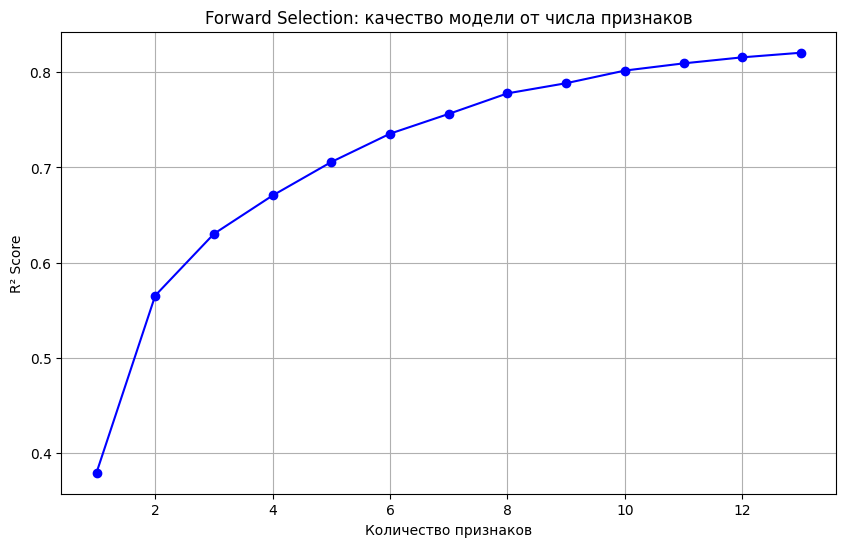

In [35]:
# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(forward_selection_scores)+1), forward_selection_scores, 'bo-')
plt.xlabel('Количество признаков')
plt.ylabel('R² Score')
plt.title('Forward Selection: качество модели от числа признаков')
plt.grid(True)
plt.show()



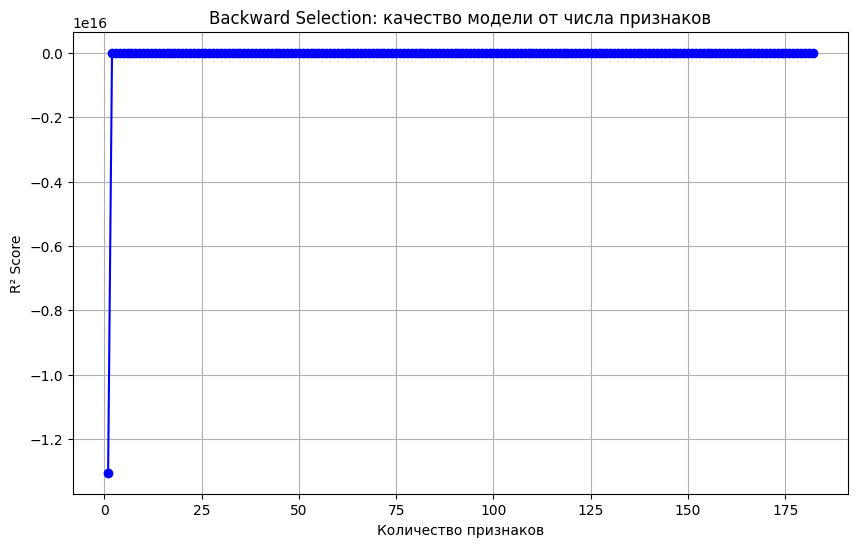

In [36]:
# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(backward_selection_scores)+1), backward_selection_scores, 'bo-')
plt.xlabel('Количество признаков')
plt.ylabel('R² Score')
plt.title('Backward Selection: качество модели от числа признаков')
plt.grid(True)
plt.show()

In [37]:
# Находим оптимальное количество признаков
forward_optimal_n_features = np.argmax(forward_selection_scores) + 1
print(f"Оптимальное количество признаков forward_selection: {forward_optimal_n_features}")

Оптимальное количество признаков forward_selection: 13


In [38]:
# Находим оптимальное количество признаков
backward_optimal_n_features = np.argmax(backward_selection_scores) + 1
print(f"Оптимальное количество признаков backward_selection: {backward_optimal_n_features}")

Оптимальное количество признаков backward_selection: 124


In [39]:
# Предположим, что features_df - это DataFrame с названиями колонок
feature_names = features_df.columns.tolist()

# Получаем названия для forward selection
forward_feature_names = [feature_names[i] for i in forward_selected_features]

# Получаем названия для backward selection  
backward_feature_names = [feature_names[i] for i in backward_selected_features]

print("Forward selected features:")
for i, (idx, name) in enumerate(zip(forward_selected_features, forward_feature_names)):
    print(f"{i+1}. {name} (index: {idx})")

print("\nBackward selected features:")
for i, (idx, name) in enumerate(zip(backward_selected_features, backward_feature_names)):
    print(f"{i+1}. {name} (index: {idx})")

Forward selected features:
1. roc_10 (index: 103)
2. dayofweek_cos (index: 128)
3. dayofweek_sin (index: 127)
4. hour_sin (index: 125)
5. min_21 (index: 61)
6. rsi_21 (index: 91)
7. macd_signal (index: 111)
8. sampen_window_300 (index: 155)
9. median_30 (index: 67)
10. min_14 (index: 54)
11. spectral_dft_mean_window_64 (index: 177)
12. lyap_exp_window_300 (index: 170)
13. hour_cos (index: 126)

Backward selected features:
1. lag_1 (index: 0)
2. diff_1 (index: 4)
3. lag_2 (index: 5)
4. ema_alpha_0.1 (index: 72)
5. dema_alpha_0.1 (index: 73)
6. tema_alpha_0.1 (index: 74)
7. ema_alpha_0.2 (index: 75)
8. tema_alpha_0.2 (index: 77)
9. dema_alpha_0.3 (index: 79)
10. ema_alpha_0.5 (index: 81)
11. dema_alpha_0.5 (index: 82)
12. tema_alpha_0.5 (index: 83)
13. ema_alpha_0.7 (index: 84)
14. tema_alpha_0.7 (index: 86)
15. ema_alpha_0.9 (index: 87)
16. tema_alpha_0.9 (index: 89)
17. roc_10 (index: 103)
18. macd_signal (index: 111)
19. macd_histogram (index: 112)
20. dayofyear (index: 123)
21. dayof

In [40]:


def display_comparison_summary(forward_features, forward_scores,
                             backward_features, backward_scores,
                             feature_names=None):
    """
    Отображает сводную таблицу сравнения методов
    """
    
    # Основная статистика
    summary_data = {
        'Metric': [
            'Total Features Selected',
            'Final R² Score',
            'Best R² Score',
            'First Feature Selected',
            'Last Feature Selected'
        ],
        'Forward Selection': [
            len(forward_features),
            forward_scores[-1] if forward_scores else None,
            max(forward_scores) if forward_scores else None,
            feature_names[forward_features[0]] if feature_names and forward_features else f'Feature {forward_features[0]}',
            feature_names[forward_features[-1]] if feature_names and forward_features else f'Feature {forward_features[-1]}'
        ],
        'Backward Selection': [
            len(backward_features),
            backward_scores[-1] if backward_scores else None,
            max(backward_scores) if backward_scores else None,
            feature_names[backward_features[-1]] if feature_names and backward_features else f'Feature {backward_features[-1]}',
            feature_names[backward_features[0]] if feature_names and backward_features else f'Feature {backward_features[0]}'
        ]
    }
    
    df_summary = pd.DataFrame(summary_data)
    
    # Общие признаки
    common_features = set(forward_features) & set(backward_features)
    common_features_list = []
    
    if common_features:
        if feature_names:
            common_features_list = [feature_names[idx] for idx in common_features]
        else:
            common_features_list = [f'Feature {idx}' for idx in common_features]
    
   
    print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА: FORWARD vs BACKWARD SELECTION")
    
    
    display(df_summary.style.set_properties(**{'text-align': 'left'}))
    
    print(f"\nОбщие важные признаки ({len(common_features)}):")
    for feature in common_features_list:
        print(f"  • {feature}")
    
    return df_summary, common_features_list





In [41]:

# Сводная статистика
df_summary, common_features = display_comparison_summary(
    forward_selected_features, forward_selection_scores,
    backward_selected_features, backward_selection_scores,
    feature_names
)





СРАВНИТЕЛЬНАЯ ТАБЛИЦА: FORWARD vs BACKWARD SELECTION


,Metric,Forward Selection,Backward Selection
0,Total Features Selected,13,23
1,Final R² Score,0.820444,0.811965
2,Best R² Score,0.820444,0.908499
3,First Feature Selected,roc_10,spectral_skewness_window_256
4,Last Feature Selected,hour_cos,lag_1



Общие важные признаки (2):
  • macd_signal
  • roc_10


In [65]:
ridge_model = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    cv=tscv,  # Используем TimeSeriesSplit для временных рядов
    scoring='neg_mean_squared_error',  # Минимизируем MSE
    n_jobs=-1,  # Используем все ядра процессора
    verbose=1
)
print("Запуск GridSearchCV...")
grid_search.fit(X_train_scaled[:, backward_selected_features], y_train_scaled)
# 5. Выводим результаты
print("\nРезультаты GridSearchCV:")
print(f"Лучший параметр alpha: {grid_search.best_params_['alpha']}")
print(f"Лучший MSE: {-grid_search.best_score_:.4f}")

best_ridge = grid_search.best_estimator_

y_test_pred_ridge = best_ridge.predict(X_test_scaled[:, backward_selected_features])
test_mse_ridge = mean_squared_error(y_test_scaled, y_test_pred_ridge)
test_r2_ridge = r2_score(y_test_scaled, y_test_pred_ridge)

print(f"\nTest результаты:")
print(f"MSE: {test_mse_ridge:.4f}")
print(f"R²: {test_r2_ridge:.4f}")

Запуск GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Результаты GridSearchCV:
Лучший параметр alpha: 100
Лучший MSE: 0.5204

Test результаты:
MSE: 0.7020
R²: 0.5594


forward_selected_features показывает лучший резульат на test

In [68]:
xgb_model = xgb.XGBRegressor(
    random_state=42,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric='rmse'
)
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}
tscv = TimeSeriesSplit(n_splits=5)  
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    verbose=1,
    return_train_score=True
)
print("Запуск GridSearchCV для XGBoost...")
grid_search.fit(
    X_train_scaled[:, backward_selected_features], y_train_scaled,
    eval_set=[(X_val_scaled[:, backward_selected_features], y_val_scaled)],  # Early stopping на validation set
    verbose=False
)
print("\nРезультаты GridSearchCV:")
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший MSE: {-grid_search.best_score_:.4f}")

best_xgb = grid_search.best_estimator_

y_test_pred_xgb = best_xgb.predict(X_test_scaled[:, backward_selected_features])
test_mse_xgb = mean_squared_error(y_test_scaled, y_test_pred_xgb)
test_r2_xgb = r2_score(y_test_scaled, y_test_pred_xgb)

print(f"\nTest результаты:")
print(f"MSE: {test_mse_xgb:.4f}")
print(f"R²: {test_r2_xgb:.4f}")

Запуск GridSearchCV для XGBoost...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Результаты GridSearchCV:
Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
Лучший MSE: 0.4217

Test результаты:
MSE: 0.7129
R²: 0.5525


In [87]:
def create_sequences(data, seq_length):
    """
    Создание последовательностей для RNN
    
    Зачем это нужно:
    RNN работают с последовательностями фиксированной длины, но наши данные - 
    это один длинный временной ряд. Мы создаем "скользящее окно":
    
    Пример: data = [100, 102, 101, 105, 107, 103], seq_length = 3
    Результат:
    X[0] = [100, 102, 101] → y[0] = 105
    X[1] = [102, 101, 105] → y[1] = 107  
    X[2] = [101, 105, 107] → y[2] = 103
    
    Это позволяет RNN учиться предсказывать следующую точку на основе истории.
    """
    X, y = [], []
    for i in range(seq_length, len(data)):
        # Берем последние seq_length точек как входную последовательность
        X.append(data[i-seq_length:i])
        # Следующая точка - это цель для предсказания
        y.append(data[i] if len(data[i].shape) == 0 else data[i, 0])
    return np.array(X), np.array(y)




In [94]:
def train_pytorch_model(model, X_train, y_train, X_val, y_val, epochs, patience, lr, batch_size):
    """Обучение PyTorch модели с GPU поддержкой"""
    # Переносим модель на устройство
    model = model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Конвертируем в тензоры и переносим на устройство
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_weights = None
    for epoch in range(epochs):
        # Обучение
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            train_pred = model(X_batch)
            train_loss = criterion(train_pred.squeeze(), y_batch)
            train_loss.backward()
            optimizer.step()
            epoch_train_loss += train_loss.item()

        # Средний loss за эпоху
        avg_train_loss = epoch_train_loss / len(train_loader)
        
        # Валидация
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred.squeeze(), y_val_tensor)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, 'f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    

    
    # Очистка GPU кэша
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Загружаем лучшие веса
    model.load_state_dict(best_model_weights)
    return  model, train_losses, val_losses




In [95]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, num_layers=2, dropout=0.2, output_size=1):
        super(SimpleLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        output = self.fc(x[:, -1, :])  # Последний выход
        return output



In [96]:
param_grid = {
    'sequence_length': [10, 20, 30, 50],
    'dropout': [0.2, 0.3],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [98]:
best_score = float('inf')
best_params = {}
    
for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
        
    # Создание последовательностей
    X_seq_train, y_seq_train = create_sequences(X_train_scaled[:, forward_selected_features], params['sequence_length'])
    X_seq_val, y_seq_val = create_sequences(X_val_scaled[:, forward_selected_features], params['sequence_length'])
        
    # Создание модели и обучение
    model = SimpleLSTM(
        input_size=X_seq_train.shape[2],
        dropout=params['dropout']
    )

    # Обучение модели
    trained_model, train_losses, val_losses = train_pytorch_model(
        model=model,
        X_train=X_seq_train,
        y_train=y_seq_train,
        X_val=X_seq_val,
        y_val=y_seq_val,
        epochs=100,
        patience=10,
        lr=params['learning_rate'],
        batch_size=params['batch_size']
    )

    # Оценка модели на валидации
    trained_model.eval()
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_seq_val).to(device)
        val_pred = trained_model(X_val_tensor)
        val_score = nn.MSELoss()(val_pred.squeeze(), torch.FloatTensor(y_seq_val).to(device)).item()
        
    if val_score < best_score:
        best_score = val_score
        best_params = params.copy()
        best_model = trained_model
        print(f"New best score! Params: {best_params}, Score: {best_score:.4f}")
    
 

Testing params: {'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'sequence_length': 10}
Epoch   0: Train Loss: 0.0227, Val Loss: 0.1318, LR: 0.001000
Epoch  10: Train Loss: 0.0446, Val Loss: 0.0900, LR: 0.001000
Epoch  20: Train Loss: 0.0412, Val Loss: 0.0916, LR: 0.001000
Early stopping at epoch 27
New best score! Params: {'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'sequence_length': 10}, Score: 0.1075
Testing params: {'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'sequence_length': 20}
Epoch   0: Train Loss: 0.0472, Val Loss: 0.1156, LR: 0.001000
Epoch  10: Train Loss: 0.0270, Val Loss: 0.1128, LR: 0.001000
Epoch  20: Train Loss: 0.0249, Val Loss: 0.0998, LR: 0.001000
Early stopping at epoch 27
New best score! Params: {'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'sequence_length': 20}, Score: 0.0789
Testing params: {'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'sequence_length': 30}
Epoch   0: Train Loss: 0.2352, Val Los

In [100]:
X_rnn_test, y_rnn_test = create_sequences(X_test_scaled[:, forward_selected_features], seq_length)

# Оценка LSTM
lstm_model.eval()
with torch.no_grad():
    lstm_pred = best_model(torch.FloatTensor(X_rnn_test).to(device))
    lstm_r2 = r2_score(y_rnn_test, lstm_pred.squeeze().cpu().numpy())
    lstm_mse = mean_squared_error(y_rnn_test, lstm_pred.squeeze().cpu().numpy())
print(f"LSTM R²: {lstm_r2:.4f}")
print(f"LSTM MSE: {lstm_mse:.4f}")

LSTM R²: 0.9218
LSTM MSE: 0.1392
